# Programming Project #2: Image Quilting

## CS445: Computational Photography - Fall 2019

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import utils
import os

In [2]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

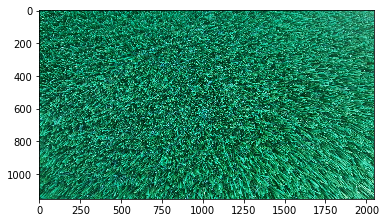

In [11]:
sample_img_dir = 'samples/grass.jpg' # feel free to change
sample_img = None
if os.path.exists(sample_img_dir):
    sample_img = cv2.imread(sample_img_dir)
    plt.imshow(sample_img)

In [12]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    if(patch_size > sample.shape[0] or patch_size > sample.shape[1]):
        print("patch size is bigger than sample image size. fix it")
        return
        
    # zero initialize our resultant image with int type    
    res = np.zeros((out_size, out_size, 3), np.uint8)
    # print("res type and shape ", type(res), res.shape)
    # print("out_size and patch_size ", out_size, patch_size)
    
    # loop in the steps of patch_size row, coloumns
    # borders that doesn't fit in the patch_size are left untouched
    for i in range(0, out_size, patch_size):
        if(i+patch_size > out_size): break
        for j in range(0, out_size, patch_size):
            if (j+patch_size > out_size): break
            noOfrow = sample.shape[0]
            noOfcol = sample.shape[1]
            # get a random row number between 0 to noOfrow in the sample_img
            # print("error here ", noOfrow, patch_size, noOfrow - patch_size)
            rowrandom = np.random.randint(low = 0, high = noOfrow - patch_size, size = 1)[0]
            # get a random col number between 0 to noOfcol in the sample_img
            colrandom = np.random.randint(low = 0, high = noOfcol - patch_size, size = 1)[0]
            res[i:i+patch_size, j:j+patch_size] = sample[rowrandom:rowrandom+patch_size, colrandom:colrandom+patch_size]
            
    return res

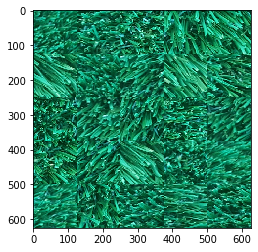

In [13]:
# while choosing out_size should be a multiple of patch_size, otherwise
# we see black area in the edges.
# Also patch_size should be less than the image sizes;
out_size = 625  # feel free to change to debug
patch_size = 125 # feel free to change to debug
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

### Part II: Overlapping Patches (30 pts)

In [6]:
import pdb
import random
import sys

# T = Template, M = Mask, I = Image
# ssd = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) +
#       cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
def ssd_patch(T, M, I):
    noOfRowI = I.shape[0]
    noOfColI = I.shape[1]
    channels = I.shape[2] # 0, 1, 2

    ssd_0 = np.zeros((noOfRowI, noOfColI), np.uint8)
    ssd_1 = np.zeros((noOfRowI, noOfColI), np.uint8)
    ssd_2 = np.zeros((noOfRowI, noOfColI), np.uint8)
    ssd_0 = ((M*T[:,:,0])**2).sum() - 2 * cv2.filter2D(I[:,:,0], ddepth=-1, kernel = M*T[:,:,0]) + cv2.filter2D(I[:,:,0] ** 2, ddepth=-1, kernel=M)
    ssd_1 = ((M*T[:,:,1])**2).sum() - 2 * cv2.filter2D(I[:,:,1], ddepth=-1, kernel = M*T[:,:,1]) + cv2.filter2D(I[:,:,1] ** 2, ddepth=-1, kernel=M)
    ssd_2 = ((M*T[:,:,2])**2).sum() - 2 * cv2.filter2D(I[:,:,2], ddepth=-1, kernel = M*T[:,:,2]) + cv2.filter2D(I[:,:,2] ** 2, ddepth=-1, kernel=M)
    
    return ssd_0 + ssd_1 + ssd_2

# input a cost image (each pixel's value is the cost 
# of selecting the patch centered at that pixel)
# find the minimum cost minc and then to sample a patch 
# within a % of that value: row, col = np.where(cost < minc*(1+tol))
# return a randomly sampled patch with low cost
def choose_sample(cost_image, tol, min_val):
    # If the minimum is approximately zero (which can happen initially), 
    # it might make sense to set minc to a larger value 
    minc = np.amin(cost_image) # find min value in cost_image
    minc = max(minc, min_val)
    # find co-ordinates of min val. return is a ndarray
    row, col = np.where(cost_image <= minc * (1 + tol))
    
    # since it is possible to have multiple values, lets just pick a randon number form the
    # list or row values.
    rand_idx = random.randrange(0, len(row)-1)
    return (row[rand_idx], col[rand_idx])    

def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Quilts square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: int
    :return: numpy.ndarray
    """
    min_val = 0.1
    res = np.zeros((out_size, out_size, 3), np.uint8)    
    for i in range(0, out_size, patch_size - overlap):
        for j in range(0, out_size, patch_size - overlap):
            
            # shrink the patch to accomodate the smaller regions in the borders.
            patch_row = min(i + patch_size, out_size) - i
            patch_col = min(j + patch_size, out_size) - j
              
            # The mask has the same size as the patch template 
            # and has values of 1 in the overlapping region 
            # and values of 0 elsewhere.
            mask = np.zeros((patch_row, patch_col))
            if (i > 0):
                mask[:overlap, :] = 1
            if (j > 0):
                mask[:, :overlap] = 1
            
            # get the area tha needs to patched from the final result image
            patch = res[i:i+patch_row, j:j+patch_col]
            
            # calculate the ssd value of the image patch, sample image
            # and the mask. mask has the overlap area covered.
            # 192,192,3:5x5:5,5,3
            cost_image = np.zeros((patch_row, patch_col), np.uint8)
            cost_image = ssd_patch(patch, mask, sample)

            # since we are looking for the minc from the patch, need to make
            # sure that other values are not selected. So marking all the other values
            # to max size. Since we are looking for only min value.
            patch_row_mid = int(patch_row/2) + 1
            patch_col_mid = int(patch_col/2) + 1
            cost_image[:patch_row_mid, :] = sys.maxsize
            cost_image[-patch_row_mid:, :] = sys.maxsize
            cost_image[:, :patch_col_mid] = sys.maxsize
            cost_image[:, -patch_col_mid:] = sys.maxsize
            
            # generate the quilt patch
            row, col = choose_sample(cost_image, tol, min_val)
            
            quilt_patch = sample[row - int(patch_row/2):row + int((patch_row+1)/2), col - int(patch_col/2):col + int((patch_col+1)/2)]
            # update the final result image with the quilt patch
            res[i:i+patch_row, j:j+patch_col] = quilt_patch       
    return res

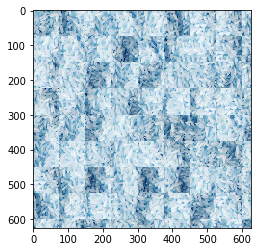

In [7]:
out_size = 625
patch_size = 125
overlap = 50
tol = 0.00006

res = quilt_simple(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
if res is not None:
    plt.imshow(res)

### Part III: Seam Finding (20 pts)


In [8]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass

In [13]:
def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    min_val = 0.1
    res = np.zeros((out_size, out_size, 3), np.uint8)    
    for i in range(0, out_size, patch_size - overlap):
        for j in range(0, out_size, patch_size - overlap):
            
            # shrink the patch to accomodate the smaller regions in the borders.
            patch_row = min(i + patch_size, out_size) - i
            patch_col = min(j + patch_size, out_size) - j
            
            di = patch_row
            dj = patch_col
            
            # The mask has the same size as the patch template 
            # and has values of 1 in the overlapping region 
            # and values of 0 elsewhere.
            mask = np.zeros((patch_row, patch_col))
            if (i > 0):
                mask[:overlap, :] = 1
            if (j > 0):
                mask[:, :overlap] = 1
            
            # get the area tha needs to patched from the final result image
            patch = res[i:i+patch_row, j:j+patch_col]
            
            # calculate the ssd value of the image patch, sample image
            # and the mask. mask has the overlap area covered.
            # 192,192,3:5x5:5,5,3
            cost_image = np.zeros((patch_row, patch_col), np.uint8)
            cost_image = ssd_patch(patch, mask, sample)

            # since we are looking for the minc from the patch, need to make
            # sure that other values are not selected. So marking all the other values
            # to max size. Since we are looking for only min value.
            patch_row_mid = int(patch_row/2) + 1
            patch_col_mid = int(patch_col/2) + 1
            cost_image[:patch_row_mid, :] = sys.maxsize
            cost_image[-patch_row_mid:, :] = sys.maxsize
            cost_image[:, :patch_col_mid] = sys.maxsize
            cost_image[:, -patch_col_mid:] = sys.maxsize
            
            
            # check from here;;;
            # generate the quilt patch
            row, col = choose_sample(cost_image, tol, min_val)
            cut_mask = np.ones((patch_size, patch_size))
            p = row
            q = col
            
            if (i > 0):
                sdif = (res[i:i+overlap,j:j+dj] - sample[p-int(di/2):p-int(di/2)+overlap,q-int(dj/2):q+int((dj+1)/2)]) ** 2
                check_mask = cut(sdif.sum(axis=2))
            
    return res

In [14]:
out_size = 625
patch_size = 125
overlap = 50
tol = 0.00006

res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.imshow(res)

ValueError: operands could not be broadcast together with shapes (25,125,3) (50,125,3) 

### part IV: Texture Transfer (30 pts)

In [ ]:
def texture_transfer(sample, target):
    """
    Feel free to add function parameters
    """
    pass

### Bells & Whistles

(10 pts) Create and use your own version of cut.m. To get these points, you should create your own implementation without basing it directly on the provided function (you're on the honor code for this one). 

You can simply copy your customized_cut(bndcost) into the box below so that it is easier for us to grade

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).